In [114]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset,Subset
import torch.optim as optim
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np, seaborn as sns
import os

In [19]:
device1 = 'cuda' if torch.cuda.is_available() else 'cpuz'

In [35]:
mean = [0.1855, 0.1855, 0.1855]
std = [0.1813, 0.1813, 0.1813]

trainsform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

testform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))])

In [24]:
# training_tf = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

In [25]:
# training_dataset = torchvision.datasets.ImageFolder(root='Dataset\Training', transform = training_tf)
# trainLOADER = torch.utils.data.DataLoader(dataset= training_dataset, batch_size=batch_size, shuffle=False)

In [30]:
# def get_mean_std(loader):
#     mean = 0.
#     std = 0.
#     totalimgCount = 0
    
#     for images, _ in loader:
#         image_count_inBatch = images.size(0)
#         print(images.shape)
#         images = images.view(image_count_inBatch, images.size(1), -1)
#         print(images.shape)
#         mean += images.mean(2).sum(0)
#         std += images.std(2).sum(0)
#         totalimgCount += image_count_inBatch
    
#     mean /= totalimgCount
#     std /= totalimgCount

#     return mean, std


In [ ]:
# get_mean_std(trainLOADER)

In [38]:
train_dataset = torchvision.datasets.ImageFolder(root='Dataset\Training', transform=trainsform)
test_dataset = torchvision.datasets.ImageFolder(root='Dataset\Testing', transform= testform)

In [43]:
def show_transformed_img(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, label = batch

    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels:', label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0231661..4.4925537].


labels: tensor([1, 2, 2, 3, 3, 0])


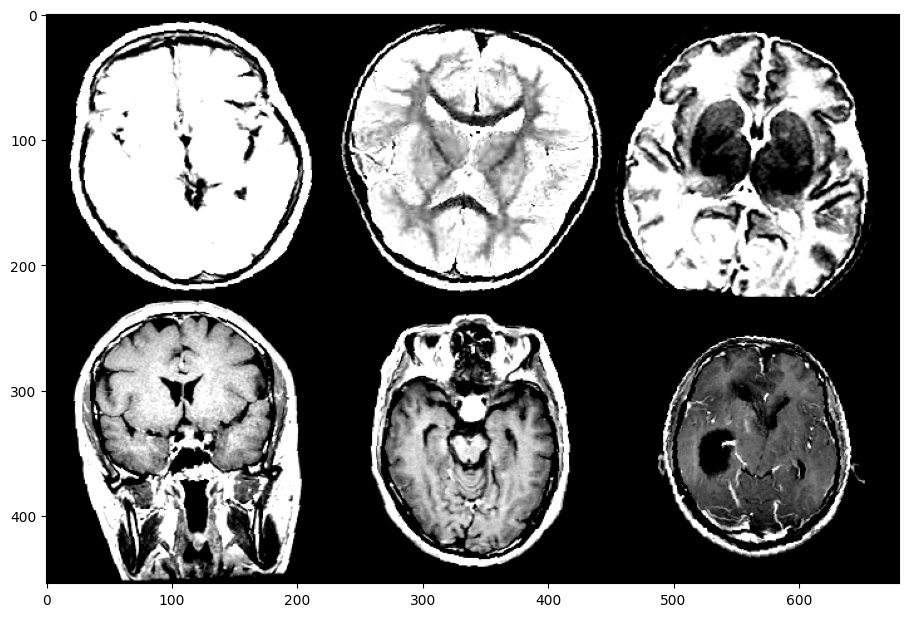

In [44]:
show_transformed_img(train_dataset)

In [67]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
        self.image_paths = []
        self.labels = []
        
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(label)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
    
        return image, label

In [101]:
train_data2 = BrainTumorDataset(root_dir='Dataset\Training',transform=trainsform)
test_data2 = BrainTumorDataset(root_dir='Dataset\Testing', transform=testform)

In [92]:
image, label = train_data2[1005]
image.shape

torch.Size([3, 224, 224])

In [45]:
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [73]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 4)  # 4 classes
    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)  # Flatten
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [53]:
model = CNNModel().to(device1)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [104]:
# Ensure the directory exists before saving
os.makedirs(os.path.dirname(save_path), exist_ok=True)

In [105]:
def training_the_model(model, criterion, optimizer, num_epochs=200, save_path='trained_CNN_brain.pth'):
    model.train()
    best_acc = 0.0

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in trainloader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device1),labels.to(device1)
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()* inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_data2)
        epoch_acc = correct / total

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), save_path)

    print(f"Training complete. Best accuracy: {best_acc:.4f}. Model saved to {save_path}")
        

In [106]:
training_the_model(model, criterion, optimizer, num_epochs=200, save_path=save_path)

Epoch [1/200], Loss: 0.3372, Accuracy: 0.8757
Epoch [2/200], Loss: 0.2195, Accuracy: 0.9223
Epoch [3/200], Loss: 0.1746, Accuracy: 0.9363
Epoch [4/200], Loss: 0.1226, Accuracy: 0.9559
Epoch [5/200], Loss: 0.1051, Accuracy: 0.9632
Epoch [6/200], Loss: 0.0763, Accuracy: 0.9767
Epoch [7/200], Loss: 0.0638, Accuracy: 0.9778
Epoch [8/200], Loss: 0.0485, Accuracy: 0.9823
Epoch [9/200], Loss: 0.0336, Accuracy: 0.9902
Epoch [10/200], Loss: 0.0274, Accuracy: 0.9925
Epoch [11/200], Loss: 0.0341, Accuracy: 0.9905
Epoch [12/200], Loss: 0.0418, Accuracy: 0.9869
Epoch [13/200], Loss: 0.0267, Accuracy: 0.9912
Epoch [14/200], Loss: 0.0183, Accuracy: 0.9935
Epoch [15/200], Loss: 0.0163, Accuracy: 0.9953
Epoch [16/200], Loss: 0.0164, Accuracy: 0.9949
Epoch [17/200], Loss: 0.0131, Accuracy: 0.9961
Epoch [18/200], Loss: 0.0471, Accuracy: 0.9860
Epoch [19/200], Loss: 0.0250, Accuracy: 0.9909
Epoch [20/200], Loss: 0.0281, Accuracy: 0.9921
Epoch [21/200], Loss: 0.0128, Accuracy: 0.9963
Epoch [22/200], Loss: 

In [108]:
def test_model(model):
    model.eval()
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device1), labels.to(device1)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    print(f"Accuracy on test set: {accuracy:.4f}")
    
    return true_labels, predictions


In [117]:
true_labels, predictions = test_model(model)

Accuracy on test set: 0.9718


In [110]:
from sklearn.metrics import confusion_matrix, classification_report,precision_recall_fscore_support

In [112]:
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=['glioma', 'meningioma', 'notumor', 'pituitary']))

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.96      0.97       300
  meningioma       0.95      0.92      0.94       306
     notumor       0.96      1.00      0.98       405
   pituitary       0.98      1.00      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



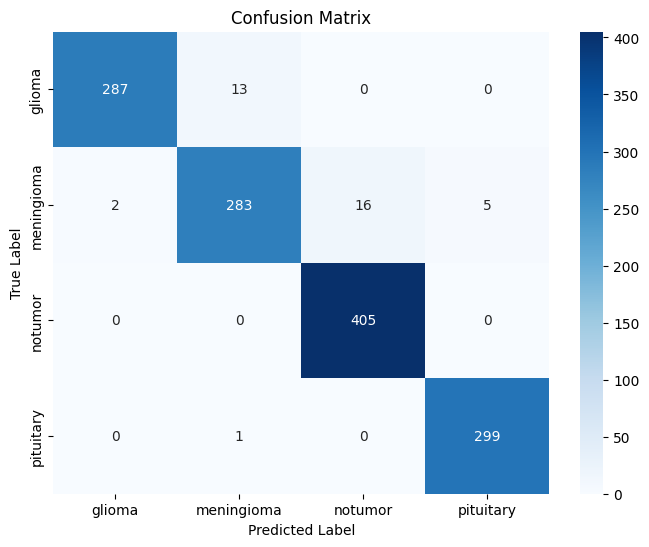

In [115]:
# Generate the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['glioma', 'meningioma', 'notumor', 'pituitary'], yticklabels=['glioma', 'meningioma', 'notumor', 'pituitary'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [116]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')
print(f"Weighted Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1_score:.4f}")

precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')
print(f"Macro-averaged Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1_score:.4f}")

Weighted Precision: 0.9719, Recall: 0.9718, F1-score: 0.9716
Macro-averaged Precision: 0.9729, Recall: 0.9695, F1-score: 0.9710
